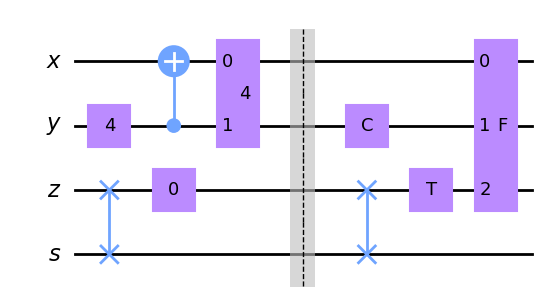

In [1]:
from machinerie import Circuit, draw404

draw404()

# Challenge 2 : Algorithme de Grover (1/2)

Étant donné une fonction $f : \{0, 1\}^n \rightarrow \{0, 1\}$, qui, par tout hasard, renvoie toujours $0$, sauf pour une entrée, où elle renvoie $1$.

Si, de nouveau par tout hasard, nous étions dans un CTF, que l'entrée particulière était le drapeau, et que nous avions accès $f$, comment ferait-on pour le récupérer ? Tester toutes les possibilités est impossible ($2^n$ possibilités), mais heureusement $f$ est quantique !

On va donc pouvoir essayer toutes les combinaisons en même temps, et récupérer le drapeau en quelques requêtes seulement !

Pour cela, nous allons utiliser l'algorithme de Grover, que je vous propose de construire pas à pas. 

## Partie 1: Création de portes $U_f$

La première étape est de rendre $f$ quantique. Une manière commune de le faire est de construire sa porte quantique associée, $U_f$, définie par : 

$$
    U_{f} |y\rangle |x\rangle = |f(x) \oplus y\rangle |x\rangle
$$

Ici, $|x\rangle$ représente $n$ qubits, tandis que $|y\rangle$ récupère le résultat, de dimension $1$. Le circuit entier sera alors de dimension $n+1$.

Par exemple, la fonction constante:
$$
    f_0: x \mapsto 1, \space \text{ou aussi:} \space f_0 = \begin{cases} 0 \rightarrow 1 \\ 1 \rightarrow 1 \end{cases}
$$
Peut se définir simplement avec:

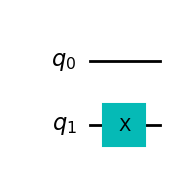

In [2]:
f0 = Circuit(2)
f0.x(1)
f0.draw_circuit()

Fait-it bien ce qu'on veut? Oui.

Dans tous les cas $f_0(x)=1$, donc l'opération sur le 2e qubit est $y \rightarrow 1 \oplus y$. Si $y=0$, $1 \oplus 0 = 1$, et si $y=1$, $1 \oplus 1 = 0$ ($a \oplus 1 = -a$). C'est exactement l'opération $X$.

On peut vérifier en mesurant : 

In [3]:
f0.get_measure()

{'10': 1.0}

Le seul qubit qui nous intéresse est celui tout à gauche, c'est celui qui correspond à $y$ (qiskit inverse les notations). Ici on a bien $\Pr(1) = 1$.

Comme on ne mesure qu'un seul qubit, on peut le faire de manière plus "propre" : 

In [4]:
from qiskit import ClassicalRegister
from qiskit.primitives import StatevectorSampler

f0 = Circuit(2)
f0.x(1)
f0.add_register(ClassicalRegister(1))  # on rajoute un bit classique de mesure
f0.barrier()  # une barrière pour faire joli
f0.measure(1, 0)  # on mesure le dernier qubit sur le 1er bit classique

results = StatevectorSampler().run([f0], shots=1).result()[0].data
for key, value in results.items():
    print(key, value.get_counts())

c0 {'1': 1}


Je vous ai fait un petit utilitaire pour l'occasion :

{'1': 1.0}


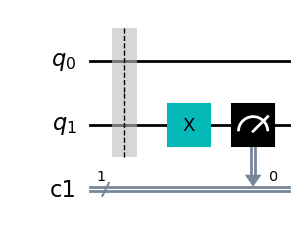

In [5]:
from machinerie import q

f0 = Circuit(2)
f0.x(1)
results = f0.get_measure(
    input_qubit=q("00"),  # circuit d'entrée
    qbits=[1],  # qubit(s) à mesurer
    shots=1024,  # nombre d'essais
    normalise=True,  # divise les résultats par le nombre d'essais
    plot_full_circuit=True,  # plot le circuit en entier pour vérifier
)
print(results)

À vous de jouer ! Construire le circuit de $f_1$, avec:

$$
    f_1: x \mapsto -x, \space \text{ou aussi:} \space f_1 = \begin{cases} 0 \rightarrow 1 \\ 1 \rightarrow 0 \end{cases}
$$

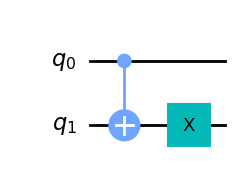

In [6]:
# solution
f1 = Circuit(2)
f1.cx(0, 1)
f1.x(1)
f1.draw_circuit()

Construire le circuit de $f_2$, avec:

$$
    f_2: \begin{cases} 0 0 \rightarrow 1 \\ 0 1 \rightarrow 0 \\ 1 0 \rightarrow 1 \\ 1 1 \rightarrow 0 \end{cases}
$$

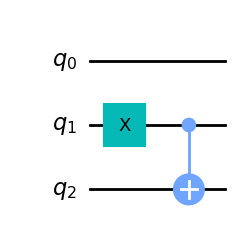

In [7]:
# solution
f2 = Circuit(3)
f2.x(1)
f2.cx(1, 2)
f2.draw_circuit()

## Entracte ($=$ rien à faire): Portes $Z_f$ et $Z_\text{or}$

Un autre moyen d'accéder à $f$ est de créer la porte $Z_f$. C'est cette porte qui va nous être utile. Elle est définie par:

$$
    Z_{f} |x\rangle = (-1)^{f(x)} |x\rangle
$$

Et peut être créée à partir de $U_f$:
$$
    U_f |x\rangle |-\rangle = (-1)^{f(x)} |x\rangle |-\rangle =
$$

Avec $|-\rangle = H|1\rangle$. 

Construire $Z_f$ de cette façon implique donc de rajouter un état "temporaire". Dans notre cas, on peut faire beaucoup mieux, en utilisant une porte $CZ$.

La porte $Z$, définie par : 
$$
    Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}
$$
Effectue un changement de phase sur $1$ : $|0\rangle \rightarrow |0\rangle, |1\rangle \rightarrow -|1\rangle$.

Sous sa version controllée, elle effectue un changement de phase si tous les états sont à $|1\rangle$. 

Par exemple, pour $f_3$ : 
$$
    f_3: \begin{cases} 0 0 \rightarrow 0 \\ 0 1 \rightarrow 0 \\ 1 0 \rightarrow 1 \\ 1 1 \rightarrow 0 \end{cases}
$$
on peut construire $Z_{f_3}$ avec le circuit suivant : 

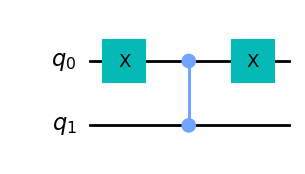

In [8]:
f3 = Circuit(2)

f3.x(0)  # le bit de droite est à 0 dans l'entrée qui nous intéresse : 10
f3.cz(
    0, 1
)  # avec la porte précédente, on a maintenant 11, on applique le changement de phase
f3.x(0)  # on rétabli l'état initial, pour 00 01 et 11, CZ n'a rien fait, et NOT NOT = I
f3.draw_circuit()

On peu donc créer un drapeau très simplement, je vous ai même fait une fonction dédiée :

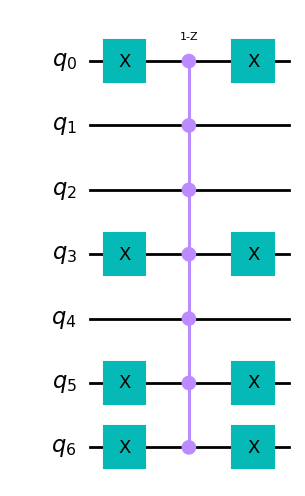

In [9]:
from machinerie import create_zf

zf = create_zf([0, 1, 1, 0, 1, 0, 0])
zf.draw_circuit()

Enfin, il nous faut une dernière porte pour notre algorithme, le $Z_\text{OR}$ !

$$
    Z_\text{OR} |x\rangle : 

    \begin{cases}
    |x \rangle \space \text{si} \space x = 0^n \\
    -|x \rangle \space \text{si} \space x \neq 0^n
\end{cases}
$$

Elle se trouve facilement en ligne, je vous la donne donc, c'est cadeau : 

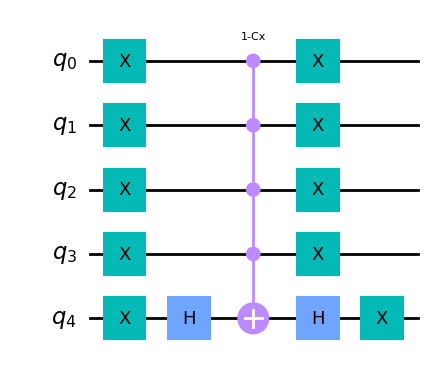

In [10]:
from machinerie import create_zor

zor = create_zor(5)
zor.draw_circuit()

Je vous laisse vérifier que ça fait bien ce qu'on veut. 

## Partie 2 : Grover

Reprenons notre fonction précédente $f_3$. On souhaite trouver quelle entrée donne $1$. Pour cela, on peut commencer par créer tous les états possibles : 

$$
    |\psi_0\rangle = \frac{1}{2} (|00\rangle + |01\rangle + |10\rangle + |11\rangle)
$$

En appliquant $Z_f$ on obtient : 
$$
    |\psi_1\rangle = Z_f |\psi_0\rangle = \frac{1}{2} (|00\rangle + |01\rangle - |10\rangle + |11\rangle)
$$

$Z_f$ a changé la phase de l'entrée recherchée, que je vais appeler $|\text{drapeau}\rangle = |10\rangle$. Si l'on voulait mesurer à cette étape, on n'obtiendrait aucun renseignement, tous les états ont la même probabilité d'apparaître : $\frac{1}{4}$. 

Toute la puissance de l'algorithme de Grover se trouve là, en appliquant les portes bien choisies $H^{\oplus n} Z_\text{OR} H^{\oplus n}$ à $|\psi_1\rangle$, la probabilité de l'état drapeau va augmenter, tandis que les autres vont diminuer. Appliquer cette procédure plusieurs fois permet de rapprocher la probabilité de sortie de l'état drapeau de $1$.

$H^{\oplus n}$ est $H$ appliqué sur $n$ qubits : 

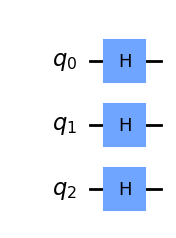

In [11]:
hn = Circuit(3)
hn.h([0, 1, 2])
hn.draw_circuit()

_Un tutoriel complet (et bien mieux expliqué qu'ici) est disponible an anglais : <https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm>_

_Une implémentation complète du cas général peut être trouvée ici : <https://learning.quantum.ibm.com/tutorial/grovers-algorithm>_


_Nous allons dans notre cas rester à $n = 2$. La deuxième partie de ce challenge est très simple, l'objectif est de vous faire découvrir l'algorithme de manière intuitive, pour préparer le challenge suivant..._ Grover (2/2). _Les idées seront aussi importantes pour un 4e challenge (2e vague)._

C'est partit !

Nous avons déjà les deux premières étapes :
$$
    |\psi_0\rangle = \frac{1}{2} (|00\rangle + |01\rangle + |10\rangle + |11\rangle)
$$
$$
    |\psi_1\rangle = Z_f |\psi_0\rangle = \frac{1}{2} (|00\rangle + |01\rangle - |10\rangle + |11\rangle)
$$
Pour appliquer $H^{\oplus 2}$ à tous les éléments de la somme correctement, on peut d'abord regarder l'effet de $H^{\oplus 2}$ sur la base canonique : 
$$
    H^{\oplus 2}|00\rangle = \frac{1}{2} (|00\rangle + |01\rangle + |10\rangle + |11\rangle) 
$$
$$
    H^{\oplus 2}|01\rangle = \frac{1}{2} (|00\rangle - |01\rangle + |10\rangle - |11\rangle) 
$$
$$
    H^{\oplus 2}|10\rangle = \frac{1}{2} (|00\rangle + |01\rangle - |10\rangle - |11\rangle) 
$$
$$
    H^{\oplus 2}|11\rangle = \frac{1}{2} (|00\rangle - |01\rangle - |10\rangle + |11\rangle) 
$$
Je vous invite à décomposer les état si ce n'est pas clair : $H^{\oplus 2}|00\rangle = (H|0\rangle) \oplus (H|0\rangle)$.

En effectuant la somme, on trouve : 
$$
    |\psi_2\rangle = H^{\oplus 2}|\psi_1\rangle = \frac{1}{2} (|00\rangle - |01\rangle + |10\rangle + |11\rangle)
$$

Ensuite, l'application de $Z_\text{OR}$ est immédiate : 
$$
    |\psi_3\rangle = Z_\text{OR}|\psi_2\rangle = \frac{1}{2} (|00\rangle + |01\rangle - |10\rangle - |11\rangle)
$$
Seul l'état $|00\rangle$ est modifié. 

Et c'est finalement à la dernière étape que la magie opère, en appliquant de nouveau $H^{\oplus 2}$, on obtient... $|\psi_4\rangle = |10\rangle$ ! Notre drapeau ! 

L'amplitudes des états $|\text{non-drapeau}\rangle$, a bien diminuée, elle est même passée à 0. Il suffit donc d'une mesure pour récupérer le drapeau, au lieu de 4 ! wow. 

En pratique, pour $n$ grand, il faut plusieurs mesures, voir même $\sqrt{n}$ si on a pas d'hypothèse sur le nombre de sequences donnant $1$. 

À vous de jouer ! 

En utilisant les portes définies précédemment, créez le circuit pour une application du protocole : $H^{\oplus 2} Z_\text{OR} H^{\oplus 2} Z_{f_3}$.

_Vous pouvez utiliser `.compose(..., inplace=True)` pour composer des circuits._

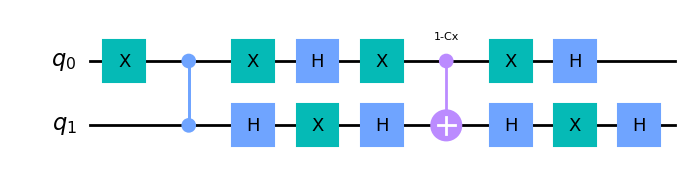

In [12]:
grover = Circuit(2)

grover.compose(f3, inplace=True)
grover.h([0, 1])
grover.compose(create_zor(2), inplace=True)
grover.h([0, 1])

grover.draw_circuit()

In [13]:
full_circuit = Circuit(2)
full_circuit.h([0, 1])

full_circuit.compose(grover, inplace=True)
full_circuit.get_measure()

{'10': 1.0}

## Récupération du drapeau !

In [ ]:
import requests
import json

data = {
    "f1": f1.get_flat_unitary(),
    "f2": f2.get_flat_unitary(),
    "grover": grover.get_flat_unitary(),
}

url = "https://causapscal-des-profondeurs.404ctf.fr/challenges/2"
headers = {"Content-Type": "application/json", "Accept": "application/json"}
response = requests.post(url, json=data, headers=headers)

print(json.loads(response.content)["message"])

GG ! Voici le drapeau : 404CTF{z0r_oU_XoR?_j3_N3_m_En_sOr_pLU5}
